In [1]:
# import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from statsmodels.formula.api import ols
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

In [2]:
# loading data set
data = pd.read_csv('Vendor_Data.csv')

In [3]:
data.head() # view of data

,Products,Avg_Price_per_unit,Cost_per_unit,Average_Profit_per_unit,Average_units_sold,Incremental_acquisition,Increase_sale_volume
0,Product 1,95,92,2.8,0.6,0.00323,0.08906
1,Product 2,37,27,10.0,0.8,0.00106,0.01991
2,Product 3,34,26,8.5,0.6,0.00328,0.03778
3,Product 4,32,30,2.8,0.7,0.00000,0.08562
4,Product 5,62,45,16.0,1.0,0.00079,0.02637


**Average Price/Unit** : Market price of the product.<br><br>
**Cost/Unit**: Current cost of the product.<br><br>
**Average Profit/Unit** : Profit for each unit.<br><br>
**Average units sold**: Average number of units of product sold to a customer who makes a purchase.<br><br>
**Incremental acquisition**: For every 10% decline in unit price, this is the increase in total customer response rate. Note that overall response rate initially is 5% (5000 out of 100000 make a purchase). You are allowed to decrease the price of a product maximum by 10% by market laws.<br><br>
**Increase in sale volume** : For every 10% decline in unit price of product, this is the increase in volume. Again, you are allowed to decrease the price of a product maximum by 10% by market laws.

In [4]:
for i in data.columns:
    print(i,len(pd.unique(data[i])))

Products 250
Avg_Price_per_unit 94
Cost_per_unit 84
Average_Profit_per_unit 151
Average_units_sold 31
Incremental_acquisition 128
Increase_sale_volume 250


In [5]:
data.isnull().sum()

Products                   0
Avg_Price_per_unit         0
Cost_per_unit              0
Average_Profit_per_unit    0
Average_units_sold         0
Incremental_acquisition    0
Increase_sale_volume       0
dtype: int64

In [6]:
data = data.drop(columns=['Products'])

In [7]:
data.shape

(250, 6)

In [8]:
data.head()

,Avg_Price_per_unit,Cost_per_unit,Average_Profit_per_unit,Average_units_sold,Incremental_acquisition,Increase_sale_volume
0,95,92,2.8,0.6,0.00323,0.08906
1,37,27,10.0,0.8,0.00106,0.01991
2,34,26,8.5,0.6,0.00328,0.03778
3,32,30,2.8,0.7,0.00000,0.08562
4,62,45,16.0,1.0,0.00079,0.02637


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Avg_Price_per_unit       250 non-null    int64  
 1   Cost_per_unit            250 non-null    int64  
 2   Average_Profit_per_unit  250 non-null    float64
 3   Average_units_sold       250 non-null    float64
 4   Incremental_acquisition  250 non-null    float64
 5   Increase_sale_volume     250 non-null    float64
dtypes: float64(4), int64(2)
memory usage: 11.8 KB


In [10]:
data.describe()

,Avg_Price_per_unit,Cost_per_unit,Average_Profit_per_unit,Average_units_sold,Incremental_acquisition,Increase_sale_volume
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,60.620000,51.596000,9.034400,1.500400,0.001366,0.050986
std,28.318959,24.182223,7.433913,0.839511,0.001579,0.029084
min,10.000000,9.000000,0.000000,0.100000,0.000000,0.000370
25%,37.000000,32.000000,3.100000,0.800000,0.000000,0.025528
50%,57.000000,50.500000,7.150000,1.400000,0.000690,0.051620
75%,85.750000,71.750000,12.975000,2.200000,0.002560,0.076580
max,110.000000,105.000000,29.700000,3.100000,0.006150,0.099430


In [11]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

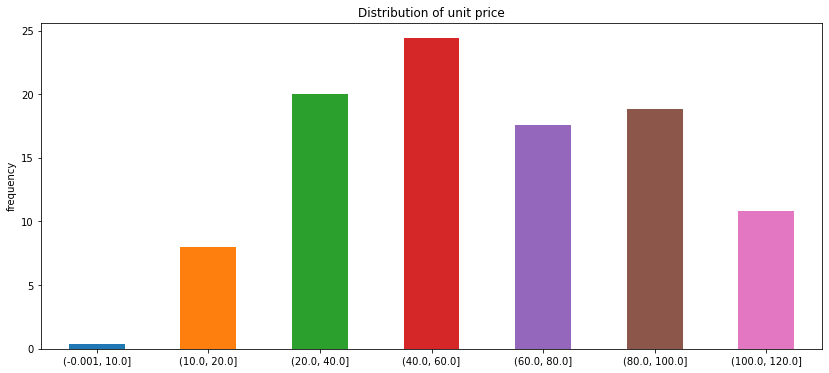

In [12]:
out = pd.cut(data['Avg_Price_per_unit'], bins=[0, 10, 20, 40,60, 80, 100, 120], include_lowest=True)
out_norm = out.value_counts(sort=False, normalize=True).mul(100)
ax = out_norm.plot.bar(rot=0, color=colors, figsize=(14,6))
plt.ylabel("frequency")
plt.title('Distribution of unit price')
plt.show()

In [13]:
profit_margin=[]
for i in range(250):
    sp=data['Avg_Price_per_unit'][i]
    cp=data['Cost_per_unit'][i]
    profit_margin.append((sp-cp)*100/cp)

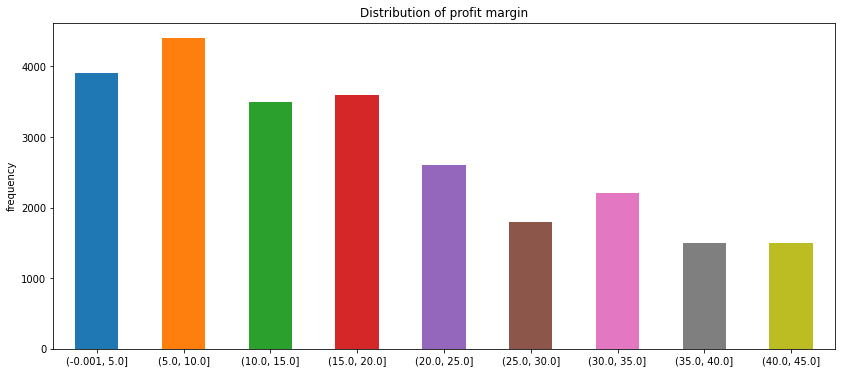

In [14]:
out = pd.cut(profit_margin, bins=[i for i in range(0,50,5)], include_lowest=True)
out_norm = out.value_counts().mul(100)
ax = out_norm.plot.bar(rot=0, color=colors, figsize=(14,6))
plt.ylabel("frequency")
plt.title('Distribution of profit margin')
plt.show()

In [15]:
# maximize total profit 

# total_profit = demand * profit_on_unit_product 

def maximize_total_profit(x,cost_price,intercept,slope):
    '''
    maximize_total_profit accepts the 'x' variable which changes by scipy model,'cost_price' is cost of a product
    'itercept' and 'slope' are values from demand equation. 
    it returns the total profit for a product.
    '''
    total_profit= -1*((slope* x + intercept)*(x-cost_price))
    return total_profit

In [16]:
# converting to numpy array from pandas series
unit_price = np.array(data['Avg_Price_per_unit'],dtype=np.float64)
unit_cost = np.array(data['Cost_per_unit'],dtype=np.float64)
units_sold = np.array(data['Average_units_sold'],dtype=np.float64)
incr_sales = np.array(data['Increase_sale_volume'],dtype=np.float64)

**ESTIMATE DEMAND MODEL:** <br>
•	A way to predict demand at specific prices<br>
•	Inverse relationship between price in demand<br>
•	Demand Equation(y=slope(b) * price(x) + intercept)<br>
&emsp;    •	y : demand<br>
&emsp;    •	b : impact of price on demand<br>
&emsp;    •	x : any price point to sell the offering<br>
&emsp;    •	intercept : starting  point of sales<br>

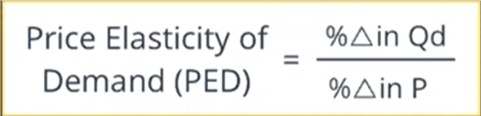

In [17]:
def demand_function(prices,quantity):
    '''
    return the price_elasticity sales_point(intercept) by consturcting the ordinary least square model
    '''
    data_item={'Price':prices,'Quantity':quantity}
    df = pd.DataFrame(data=data_item) # converting  dictionary to  DataFrame
    ols_model = ols("Quantity~Price", data=df).fit() # fitting ols model
    price_elasticity = ols_model.params[1] # slope from ols model
    sales_point = ols_model.params[0] # intercept from ols model
    return (price_elasticity,sales_point)

<h1>Price vs Quantity</h1>
<br><br>
<p style="display:inline;text-align:left"><img src="demand_curve.webp" alt="Sunflower" style="width: 300px;float: right; margin-right: 15px;">An increase in quantity demanded is caused by a decrease in the price of the product (and vice versa). A demand curve illustrates the quantity demanded and any price offered on the market. A change in quantity demanded is represented as a movement along a demand curve. The proportion that quantity demanded changes relative to a change in price is known as the elasticity of demand and is related to the slope of the demand curve.</p>



In [18]:
def price_optimizer():
    '''
        calculating optimal price for the products
    '''
    total_initial_profit=0
    total_optimized_profit=0
    optimal_prices=[]
    number_of_products = data.shape[0]
    for i in range(number_of_products):
        p1=unit_price[i]
        q1 = units_sold[i]
        p2=90*p1/100
        q2=(100+incr_sales[i])*q1/100
        prices=[p1,p2]
        qunatity=[q1,q2]
        slope,intercept = demand_function(prices,qunatity) # receiving slope and intercept from ols model 
        
        selling_price=unit_price[i]
        constraint=[(float(max(unit_cost[i],unit_price[i]*0.9))
                     ,unit_price[i]*1.2)] # setting constraints for the selling price (-10%,20%)
        
        maximize_result = minimize(maximize_total_profit,selling_price
                                   ,args=(unit_cost[i],intercept,slope*100)
                                   ,method='SLSQP',bounds=constraint) # receiving the maximized value for selling price
        total_initial_profit+=(selling_price-unit_cost[i])*units_sold[i]
        optimal_prices.append(maximize_result.x[0]) # optimal price list
        total_optimized_profit+=(maximize_result.x[0]-unit_cost[i])*units_sold[i] # total optimal price
        
    return optimal_prices,total_initial_profit,total_optimized_profit

In [19]:
optimal_prices, total_initial_profit, total_optimized_profit =  price_optimizer()

In [20]:
d={'selling_price':unit_price,'optimal_selling_price':optimal_prices }
result=pd.DataFrame(data=d)
result.head()

,selling_price,optimal_selling_price
0,95.0,99.809833
1,37.0,44.400000
2,34.0,40.800000
3,32.0,33.847223
4,62.0,74.400000


In [21]:
print("profit before optimization :",total_initial_profit)
print("profit after optimization :",total_optimized_profit)

profit before optimization : 3285.8999999999996
profit after optimization : 6600.85076980578
